In [4]:
from __future__ import print_function
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
from sklearn.linear_model import RidgeCV

In [6]:
data = pd.read_hdf("Datasets/mergedCHEMBLDF.h5","data")

In [7]:
data.columns

Index([u'stdInChiKey', u'1613933_operator', u'1613933_value',
       u'1614063_operator', u'1614063_value', u'1614364_operator',
       u'1614364_value', u'1614421_operator', u'1614421_value',
       u'1794557_operator', u'1794557_value', u'1909116_operator',
       u'1909116_value', u'1909123_operator', u'1909123_value',
       u'1909130_operator', u'1909130_value', u'1909184_operator',
       u'1909184_value', u'1909186_operator', u'1909186_value',
       u'1909187_operator', u'1909187_value', u'1909194_operator',
       u'1909194_value', u'1909195_operator', u'1909195_value',
       u'1909196_operator', u'1909196_value', u'2218781_operator',
       u'2218781_value', u'2328568_operator', u'2328568_value',
       u'3705123_operator', u'3705123_value', u'3705362_operator',
       u'3705362_value', u'3705488_operator', u'3705488_value',
       u'3706373_operator', u'3706373_value', u'smiles', u'smiles_parent',
       u'morgan', u'combi'],
      dtype='object')

In [8]:
assays = [1614421,1614364,1613933,1909116,1909123,1909130,1909187,1909186,1909184,1909194,1909195,1909196,2328568,1794557,3706373,3705123,1614063,3705488,3705362,2218781]

In [52]:
prefix = "Chembl_"

In [53]:
assay = assays[-1]

In [74]:
def test_assay(assay, collector):
    results = {}
    #Get y_data
    y_all = data[str(assay)+ "_value"]

    #Identify rows that are not null/NaN
    mask = ~y_all.isnull()
    results["Datapoints"] = np.sum(mask)

    try:
        y = np.log(y_all[mask])
    except:
        print("Fail")
        results["Error"] = "Fail" #TODO give exception type
        collector[assay] = results
        return collector
    
    plt.figure()
    plt.hist(y)
    plt.title("%s %s Y values"%(prefix,assay))
    plt.savefig("Images/%s%s_yhist.png"%(prefix, assay))

    #Get X-data
    X = np.array(list(data["morgan"][mask]))

    #Remove features with low variance
    from sklearn.feature_selection import VarianceThreshold
    vt = VarianceThreshold(0.01)
    X_red = vt.fit_transform(X)
    results["Low var features"] = X_red.shape[1]

    #Split in train-test
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X_red, y, test_size=0.1, random_state=42)

    #Dimension reduction
    from sklearn.decomposition import PCA
    pca = PCA(n_components=250)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

    results["PCA explained variance"] = np.sum(pca.explained_variance_ratio_)

    #first round of CV grid search
    alphas = np.logspace(6,-6, 20)
    #L2 regularized multiple linear regression
    regr = RidgeCV(alphas=alphas,store_cv_values=True)
    regr.fit(X_train,y_train)

    test_scores = np.mean(regr.cv_values_, axis = 0)
    best_idx = np.argmin(test_scores)
    #Second round of CV grid search
    zoom_alphas = np.logspace(np.log10(alphas[best_idx-1]), np.log10(alphas[best_idx+1]), 10)
    regr = RidgeCV(alphas=zoom_alphas, store_cv_values=True)
    regr.fit(X_train,y_train)

    #Combine and plot
    x_axis = np.concatenate([alphas, zoom_alphas])
    sortidx = np.argsort(x_axis)
    test_scores = np.concatenate([test_scores, np.mean(regr.cv_values_, axis=0)])

    plt.figure()
    plt.plot(x_axis[sortidx], test_scores[sortidx])
    plt.xscale('log')
    plt.title("%s %s Tuning"%(prefix,assay))
    plt.xlabel("Alpha")
    plt.ylabel("CV fit")
    plt.savefig("Images/%s%s_tuning.png"%(prefix, assay))


    results["Found Alpha"] = regr.alpha_

    plt.figure()                         
    y_train_pred = regr.predict(X_train)
    y_test_pred = regr.predict(X_test)

    score_train = regr.score(X_train,y_train)
    score_test = regr.score(X_test,y_test)
    
    results["Train R^2"] = score_train
    results["Test R^2"] = score_test

    plt.scatter(y_train,y_train_pred, label="Train")
    plt.scatter(y_test, y_test_pred, label="Test")
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title("Assay %s Train %0.2F, Test %0.2F"%(assay, score_train, score_test))
    plt.legend()
    plt.savefig("Images/%s%s_scatter.png"%(prefix, assay))
    
    
    
    collector[assay ] = results
    return collector

Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail
Fail


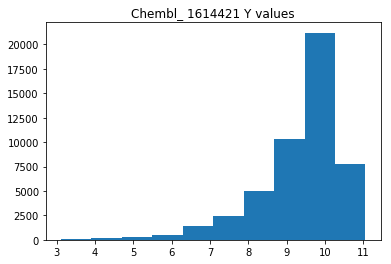

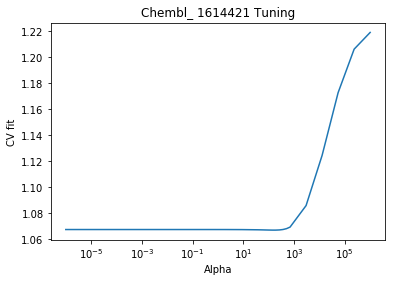

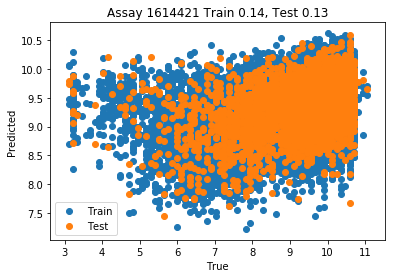

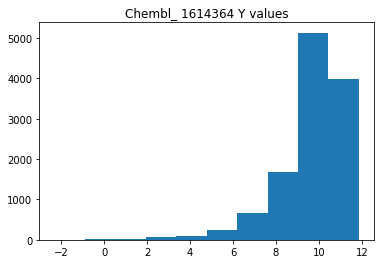

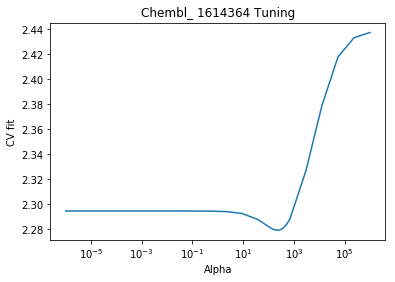

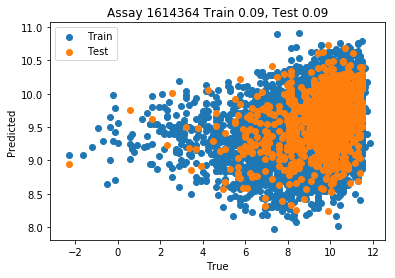

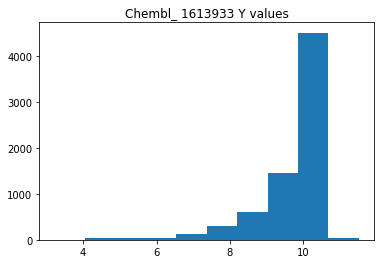

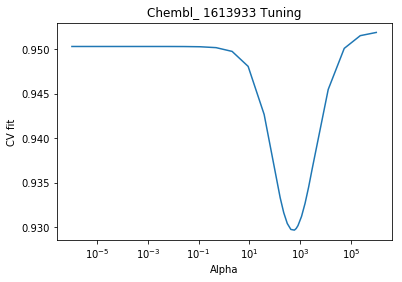

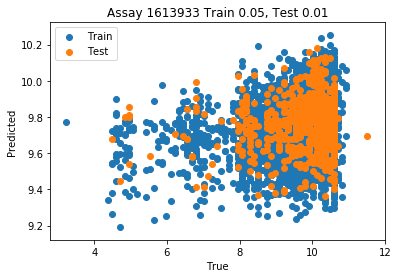

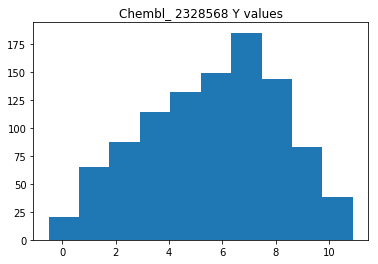

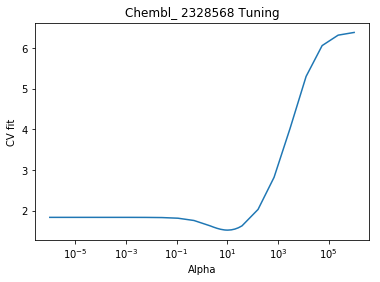

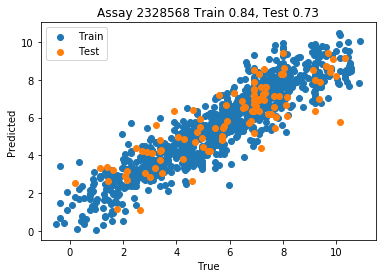

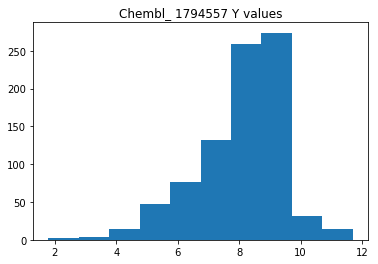

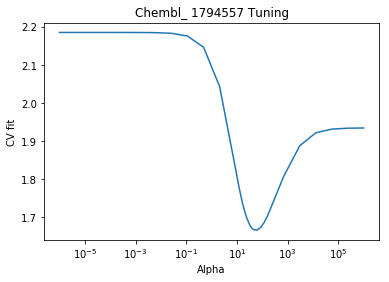

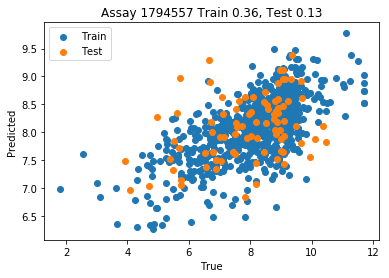

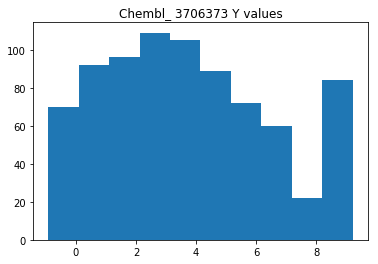

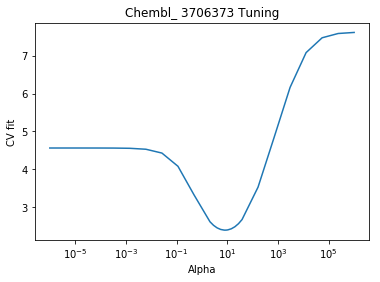

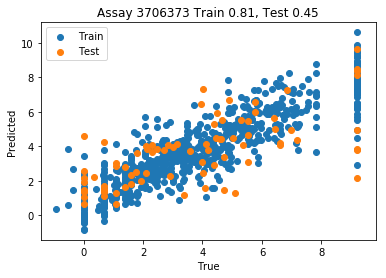

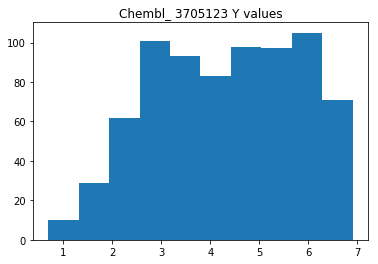

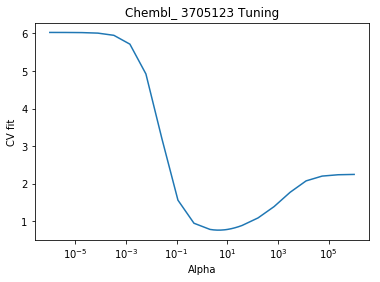

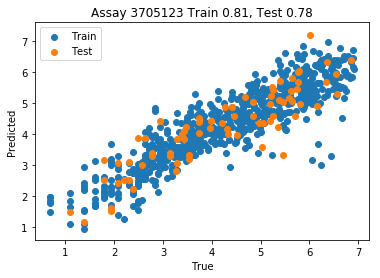

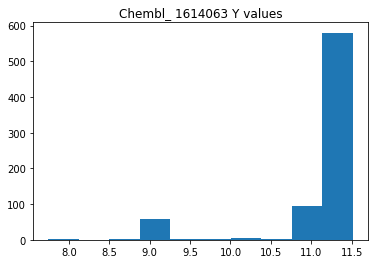

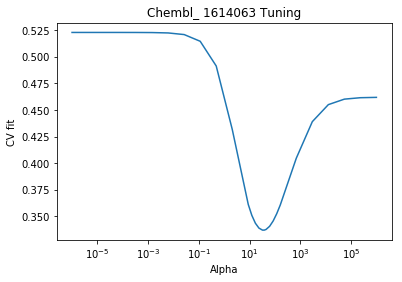

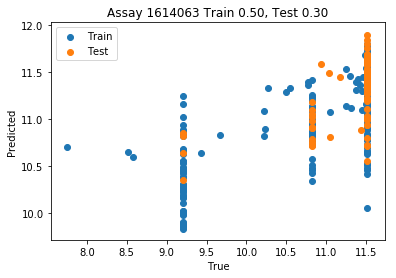

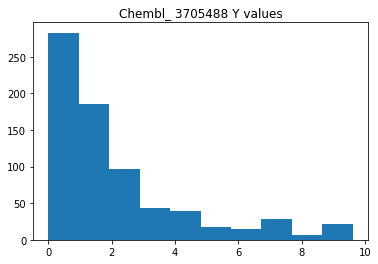

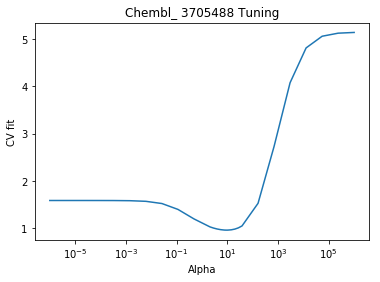

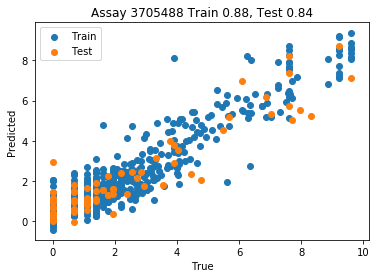

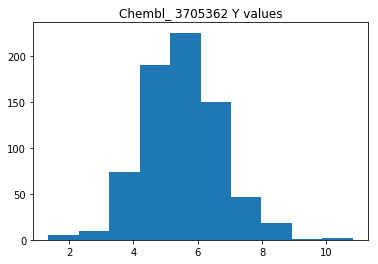

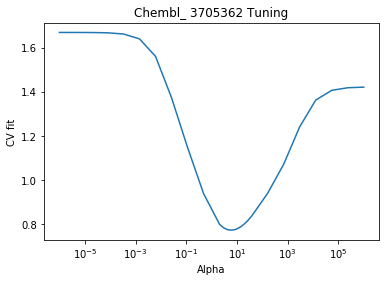

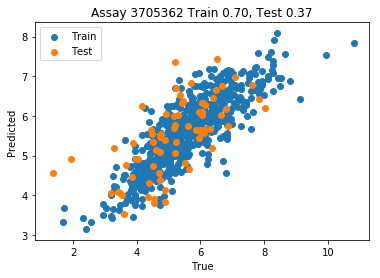

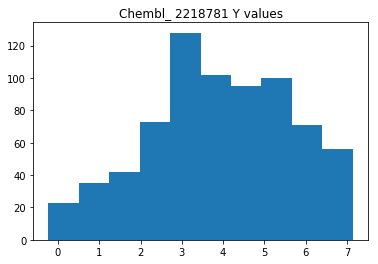

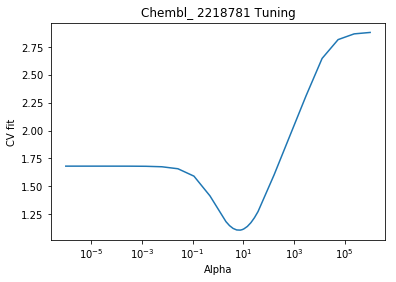

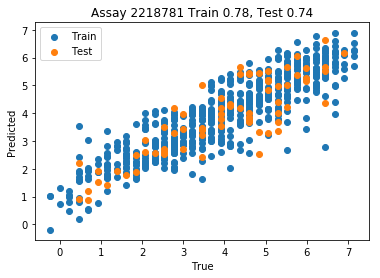

In [75]:
collector = {}
for assay in assays:
    collector = test_assay(assay, collector)

In [80]:
results = pd.DataFrame(collector).T
results

,Datapoints,Error,Found Alpha,Low var features,PCA explained variance,Test R^2,Train R^2
1613933,7149,NaN,591.466,861,0.854002,0.0138917,0.0518591
1614063,744,NaN,32.268,878,0.979085,0.3047,0.500579
1614364,11880,NaN,263.665,845,0.845175,0.08526,0.0925366
1614421,49111,NaN,138.15,889,0.836282,0.133839,0.137488
1794557,854,NaN,61.5848,946,0.927696,0.12554,0.362059
1909116,835,Fail,NaN,NaN,NaN,NaN,NaN
1909123,835,Fail,NaN,NaN,NaN,NaN,NaN
1909130,835,Fail,NaN,NaN,NaN,NaN,NaN
1909184,835,Fail,NaN,NaN,NaN,NaN,NaN
1909186,835,Fail,NaN,NaN,NaN,NaN,NaN


In [82]:
results.to_excel("Chembl_evaluation.xls")